In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.const import init_const
from aeolus.plot import add_custom_legend, subplot_label_generator
from aeolus.synthobs import calc_stellar_flux, read_spectral_bands

In [3]:
from util_commons import PLANETS, SUITES
from util_mypaths import path_to_constants, path_to_obs, path_to_results
from util_plot_func import use_draft_style, use_paper_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
use_paper_style()
# use_draft_style()

In [5]:
# Parameters
metallicity = "solar"

hatp11b_const = init_const("hatp11b", directory=path_to_constants)
hd189733b_const = init_const("hd189733b", directory=path_to_constants)
hd209458b_const = init_const("hd209458b", directory=path_to_constants)
wasp17b_const = init_const("wasp17b", directory=path_to_constants)
PLANET_CONSTS = [hatp11b_const, hd189733b_const, hd209458b_const, wasp17b_const]

In [6]:
# Calculate Fp over Fs from the UM
vrbls = {}
for planet, planet_const in tqdm(zip(PLANETS.keys(), PLANET_CONSTS)):
    vrbls[planet] = {}
    for exp in tqdm(["equilibrium", "kinetics"]):
        vrbls[planet][exp] = {}
        # Load data
        star_constant_at_1_au = planet_const.star_constant_at_1_au
        path_to_spectral_file = SUITES[planet][exp][metallicity]["dir_for_star_spectrum_sw"]
        path_to_phase_curves = SUITES[planet][exp][metallicity][f"dir_for_phase_curves"]
        # SW EMISSION SPECTRUM
        sw_planet_flux = iris.load_cube(str(path_to_phase_curves), "m01s01i713")
        # LW EMISSION SPECTRUM
        lw_planet_flux = iris.load_cube(str(path_to_phase_curves), "m01s02i713")
        # Calculate stellar flux
        stellar_flux = calc_stellar_flux(path_to_spectral_file, star_constant_at_1_au)
        # Calculate planetary flux as a sum of the shortwave and longwave emission across the planet
        sw_planet_flux_sum = sw_planet_flux.collapsed(["latitude", "longitude"], iris.analysis.SUM)
        lw_planet_flux_sum = lw_planet_flux.collapsed(["latitude", "longitude"], iris.analysis.SUM)
        planet_flux = sw_planet_flux_sum + lw_planet_flux_sum
        planet_flux.coord("pseudo_level").rename("spectral_band_index")
        # Divide the planetary flux by the stellar flux
        fp_over_fs = planet_flux / stellar_flux
        # Find spectral band centers
        spectral_bands = read_spectral_bands(path_to_spectral_file)
        spectral_band_centers = 0.5 * (
            spectral_bands["lower_wavelength_limit"] + spectral_bands["upper_wavelength_limit"]
        )
        # Assemble data
        vrbls[planet][exp] = {
            "spectral_band_centers": spectral_band_centers,
            "fp_over_fs": fp_over_fs,
        }

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

#### Observations of the secondary eclipse depth used in this work
1. NASA Exoplanet Archive emission spectra https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=emissionspec
    - downloaded on 220324 (no data for HAT-P-11b and WASP-17b as of 220324)
    - central wavelength [micrometers]
    - eclipse depth (referred to here as fp_over_fs) [%]
    - eclipse depth uncertainty [%]

HD 189733b:

2. Swain2009 Table 1 https://iopscience.iop.org/article/10.1088/0004-637X/690/2/L114
    - 1.476-2.446 $\mu$m
    - wavelength [micrometers]
    - contrast $F_{planet}/F_{star}$ spectrum of the dayside (referred to here as fp_over_fs) [unitless]
    - $1 - \sigma$ error for the contrast $F_{planet}/F_{star}$ spectrum of the dayside [unitless]
3. Charbonneau2008 Table 1 https://iopscience.iop.org/article/10.1086/591635
    - 3.6, 4.5, 5.8, 8.0, 16, 24 $\mu$m
    - wavelength [micrometers]
    - relative eclipse depth (referred to here as fp_over_fs) [unitless]
    - relative eclipse depth error [unitless]
    
HD 209458b:

4. Swain2009 Figure 3 https://iopscience.iop.org/article/10.1088/0004-637X/704/2/1616
    - 1.525-2.436 $\mu$m
    - wavelength [micrometers]
    - $F_p/F_s$ (referred to here as fp_over_fs) [1e-3]
    - $F_p/F_s$ error
    - These data were extracted from Swain2009 by Elsie Lee using webplotdigitiser.
5. Evans2015 Table 4 https://academic.oup.com/mnras/article/451/1/680/1357462; reanalysis of the data in Knutson2008, Zellem2014, Diamond-Lowe2014
    - 3.6, 4.5, 5.8, 8.0 $\mu$m
    - wavelength [micrometers]
    - $F_p/F_*$ (referred to here as fp_over_fs) [%]
    - $F_p/F_*$ error [%]
6. Swain2008 Table 3 https://iopscience.iop.org/article/10.1086/523832; reanalysis of the data in Richardson2007
    - 7.67-14.44 $\mu$m
    - wavelength [micrometers]
    - planet/star contrast spectrum (referred to here as fp_over_fs) [unitless]
    - $1 \sigma$ error for the planet/star contrast spectrum [unitless]
    
WASP-17b:

7. Anderson2011 Table 5 https://academic.oup.com/mnras/article/416/3/2108/962379
    - 4.5, 8.0 $\mu$m
    - wavelength [micrometers]
    - relative planet-star flux [unitless]
    - relative planet-star flux error

In [7]:
# NASA Exoplanet Archive emission spectra downloaded on 220324
path_to_obs_nasa = path_to_obs / "nasa_exoplanet_archive" / "emissionspec_2022.03.24_02.50.46.csv"
obs = pd.read_csv(path_to_obs_nasa, header=22)
obs_dict = {
    "hd189733b": {
        "Agol2010": obs.loc[
            (obs.plntname == "HD 189733 b") & (obs.plntreflink.str.contains("Agol et al. 2010"))
        ],
        "Deming2006": obs.loc[
            (obs.plntname == "HD 189733 b") & (obs.plntreflink.str.contains("Deming et al. 2006"))
        ],
        "Charbonneau2008": obs.loc[
            (obs.plntname == "HD 189733 b")
            & (obs.plntreflink.str.contains("Charbonneau et al. 2008"))
        ],
        "Knutson2009": obs.loc[
            (obs.plntname == "HD 189733 b") & (obs.plntreflink.str.contains("Knutson et al. 2009"))
        ],
        "Swain2009": obs.loc[
            (obs.plntname == "HD 189733 b") & (obs.plntreflink.str.contains("Swain et al. 2009"))
        ],
    },
    "hd209458b": {
        "Evans2015": obs.loc[
            (obs.plntname == "HD 209458 b") & (obs.plntreflink.str.contains("Evans et al. 2015"))
        ],
        "Knutson2008": obs.loc[
            (obs.plntname == "HD 209458 b") & (obs.plntreflink.str.contains("Knutson et al. 2008"))
        ],
        "Crossfield2012": obs.loc[
            (obs.plntname == "HD 209458 b")
            & (obs.plntreflink.str.contains("Crossfield et al. 2012"))
        ],
        "Zellem2014": obs.loc[
            (obs.plntname == "HD 209458 b") & (obs.plntreflink.str.contains("Zellem et al. 2014"))
        ],
        "Diamond-Lowe2014": obs.loc[
            (obs.plntname == "HD 209458 b")
            & (obs.plntreflink.str.contains("Diamond-Lowe et al. 2014"))
        ],
        "Line2016": obs.loc[
            (obs.plntname == "HD 209458 b") & (obs.plntreflink.str.contains("Line et al. 2016"))
        ],
    },
}

In [8]:
# HD 189733b Swain2009 Table 1
path_to_obs_swain2009 = path_to_obs / "hd189733b_Swain2009.txt"
_df_swain2009 = pd.read_csv(
    path_to_obs_swain2009,
    skiprows=6,
    sep="\s+",
    names=["wavelength", "fp_over_fs", "fp_over_fs_err"],
)
df_swain2009 = _df_swain2009[::-1].reset_index(drop=True)

# HD 189733b Charbonneau2008 Table 1
path_to_obs_charbonneau2008 = path_to_obs / "hd189733b_Charbonneau2008.txt"
df_charbonneau2008 = pd.read_csv(
    path_to_obs_charbonneau2008,
    skiprows=3,
    sep="\t",
    names=[
        "wavelength",
        "fp_over_fs",
        "fp_over_fs_err",
        "center_of_eclipse",
        "center_of_eclipse_err",
        "O-C",
        "O-C_err",
    ],
)

# HD 189733b Grillmair2008 Figure 1 via WebPlotDigitizer (not a good way of getting the data)
path_to_obs_grillmair2008 = path_to_obs / "hd189733b_Grillmair2008.csv"
df_grillmair2008 = pd.read_csv(
    path_to_obs_grillmair2008,
    sep=",",
    names=[
        "wavelength",
        "fp_over_fs",
        #         "fp_over_fs_err",
    ],
)

In [9]:
# HD 209458b Swain2009 Figure 3
path_to_obs_swain2009_hd209458b = path_to_obs / "hd209458b_Swain2009.txt"
df_swain2009_hd209458b = pd.read_csv(
    path_to_obs_swain2009_hd209458b,
    skiprows=3,
    sep="\s+",
    names=[
        "wavelength",
        "fp_over_fs",
        "fp_over_fs_err",
    ],
)

# HD 209458b Evans2015 Table 4
evans2015 = {
    "hd209458b": {
        3.6: {
            "2005 Nov 28": {
                "fp_over_fs": 0.093,
                "fp_over_fs_plus": 0.033,
                "fp_over_fs_minus": 0.034,
                "date": "2005 Nov 28",
            },
            "2011 Jan 12": {
                "fp_over_fs": 0.122,
                "fp_over_fs_plus": 0.011,
                "fp_over_fs_minus": 0.011,
                "date": "2011 Jan 12",
            },
            "2011 Jan 16": {
                "fp_over_fs": 0.124,
                "fp_over_fs_plus": 0.014,
                "fp_over_fs_minus": 0.014,
                "date": "2011 Jan 16",
            },
            "2014 Feb 13": {
                "fp_over_fs": 0.112,
                "fp_over_fs_plus": 0.016,
                "fp_over_fs_minus": 0.017,
                "date": "2014 Feb 13",
            },
            "2014 Feb 17": {
                "fp_over_fs": 0.106,
                "fp_over_fs_plus": 0.007,
                "fp_over_fs_minus": 0.008,
                "date": "2014 Feb 17",
            },
        },
        4.5: {
            "2005 Nov 28": {
                "fp_over_fs": 0.145,
                "fp_over_fs_plus": 0.018,
                "fp_over_fs_minus": 0.017,
                "date": "2005 Nov 28",
            },
            "2010 Jan 18": {
                "fp_over_fs": 0.140,
                "fp_over_fs_plus": 0.014,
                "fp_over_fs_minus": 0.014,
                "date": "2010 Jan 18",
            },
            "2010 Jan 21": {
                "fp_over_fs": 0.133,
                "fp_over_fs_plus": 0.011,
                "fp_over_fs_minus": 0.011,
                "date": "2010 Jan 21",
            },
        },
        5.8: {
            "2005 Nov 28": {
                "fp_over_fs": 0.142,
                "fp_over_fs_plus": 0.059,
                "fp_over_fs_minus": 0.058,
                "date": "2005 Nov 28",
            }
        },
        8.0: {
            "2005 Nov 28": {
                "fp_over_fs": 0.225,
                "fp_over_fs_plus": 0.064,
                "fp_over_fs_minus": 0.063,
                "date": "2005 Nov 28",
            },
            "2007 Dec 25": {
                "fp_over_fs": 0.215,
                "fp_over_fs_plus": 0.012,
                "fp_over_fs_minus": 0.012,
                "date": "2007 Dec 25",
            },
        },
    },
}

# HD 209458b Swain2008 Table 3
swain2008 = {
    "hd209458b": {
        "wavelength": [
            7.67,
            8.15,
            8.63,
            9.12,
            9.60,
            10.09,
            10.57,
            11.05,
            11.54,
            12.02,
            12.51,
            12.99,
            13.47,
            13.96,
            14.44,
        ],
        "fp_over_fs": [
            0.0031,
            0.0027,
            0.0032,
            0.0033,
            0.0032,
            0.0031,
            0.0033,
            0.0034,
            0.0030,
            0.0033,
            0.0032,
            0.0033,
            0.0025,
            0.0029,
            0.0040,
        ],
        "fp_over_fs_err": [
            0.00025,
            0.00019,
            0.00020,
            0.00022,
            0.00022,
            0.00021,
            0.00023,
            0.00026,
            0.00028,
            0.00029,
            0.00029,
            0.00033,
            0.00040,
            0.00046,
            0.00049,
        ],
    }
}

In [10]:
# WASP-17b Anderson2011 Table 5
anderson2011 = {
    "wasp17b": {
        "wavelength": [4.5, 8.0],
        "fp_over_fs": [0.00229, 0.00237],
        "fp_over_fs_err": [0.00013, 0.00039],
    }
}

In [11]:
# Plotting options
xticks = np.concatenate(
    [
        np.arange(2, 10, 1),
        np.array([10, 15, 20, 30]),
    ]
)
# Find spectral band center < 30 micrometers and its index
# (spectral bands are ordered from longwave to shortwave)
band_ctr0_val, band_ctr0_idx = next(
    ((j, i) for i, j in enumerate(spectral_band_centers * 1e6) if j < 30), None
)
print(band_ctr0_val, band_ctr0_idx)
print(spectral_band_centers[32] * 1e6, spectral_band_centers[33] * 1e6)

29.857397 33
30.77651490457356 29.857397748855874


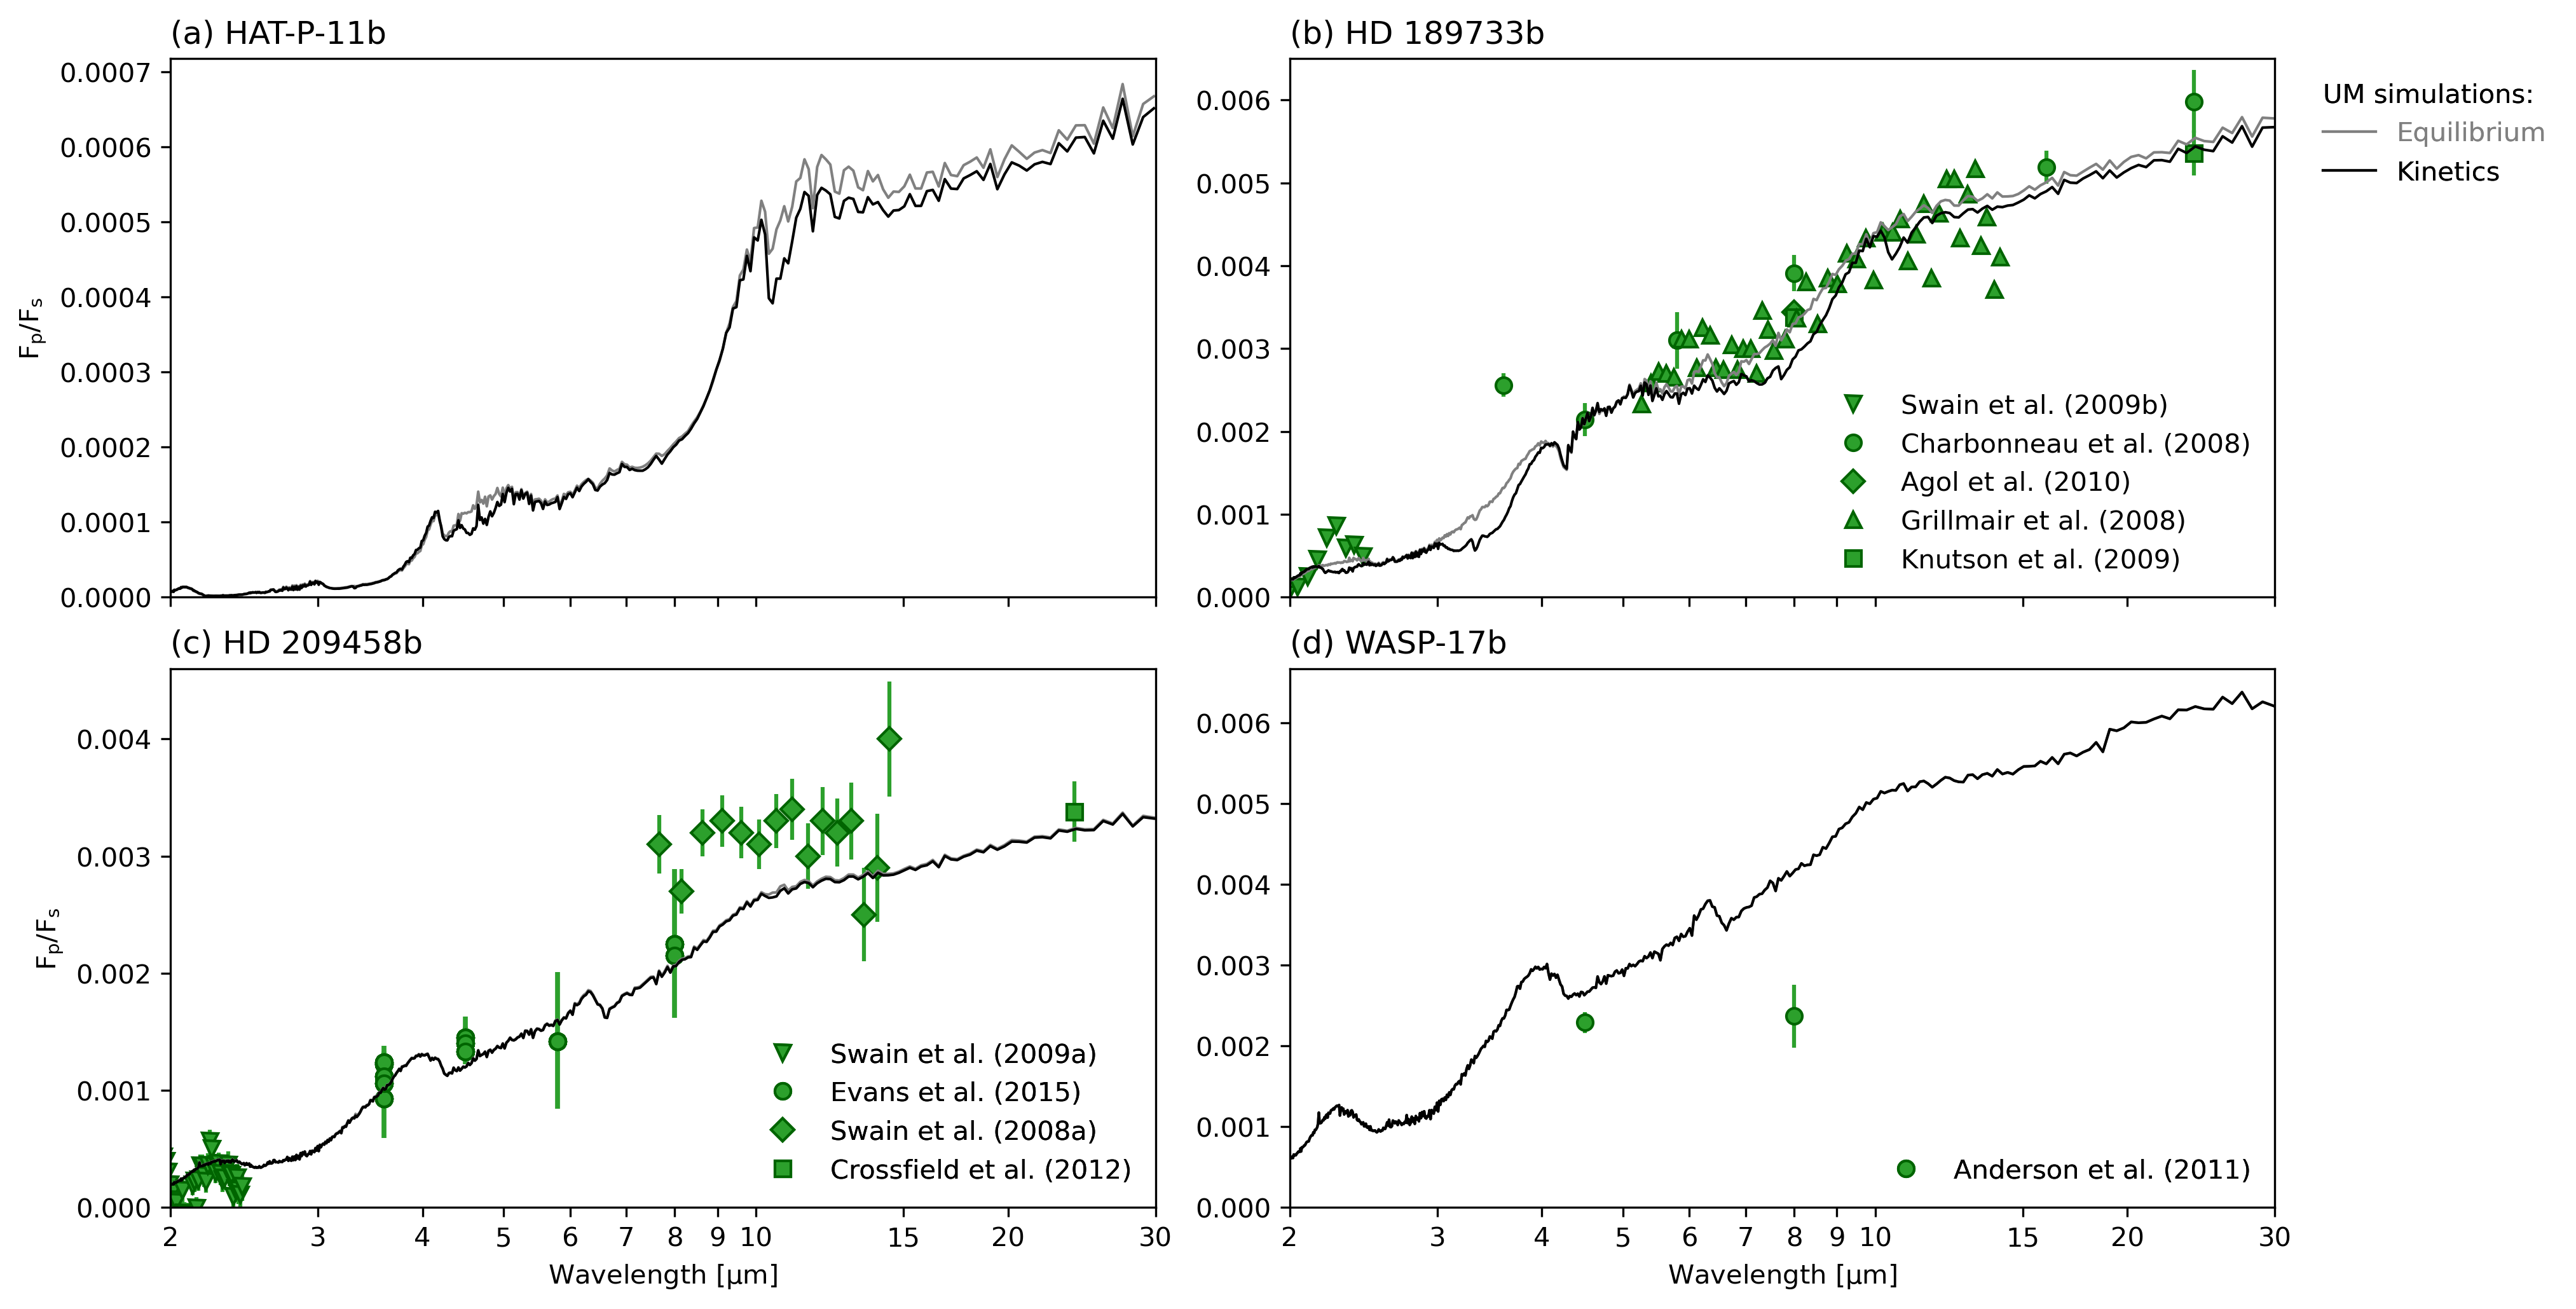

In [12]:
# Plot the observed and UM emission spectra
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6.75), constrained_layout=True, sharex=True)
iletters = subplot_label_generator()
for planet, ax in zip(PLANETS.keys(), axes.flatten()):
    ax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")

    # Add the observed secondary eclipse depth
    if planet == "hd189733b":
        ax.set_ylim(0, 0.0065)
        hd189733b_plt_kw = {
            "Swain et al. (2009b)": {
                "color": "C2",
                "linestyle": "",
                "marker": "v",
                "markeredgecolor": "darkgreen",
            },
            "Charbonneau et al. (2008)": {
                "color": "C2",
                "linestyle": "",
                "marker": "o",
                "markeredgecolor": "darkgreen",
            },
            "Agol et al. (2010)": {
                "color": "C2",
                "linestyle": "",
                "marker": "D",
                "markeredgecolor": "darkgreen",
            },
            "Grillmair et al. (2008)": {
                "color": "C2",
                "linestyle": "",
                "marker": "^",
                "markeredgecolor": "darkgreen",
            },
            "Knutson et al. (2009)": {
                "color": "C2",
                "linestyle": "",
                "marker": "s",
                "markeredgecolor": "darkgreen",
            },
        }
        add_custom_legend(ax, hd189733b_plt_kw, frameon=False, loc="lower right")
        for ref, marker in zip([df_swain2009, df_charbonneau2008], ["v", "o"]):
            x = ref["wavelength"]
            y = ref["fp_over_fs"]
            yerr_minus = ref["fp_over_fs_err"]
            yerr_plus = ref["fp_over_fs_err"]
            yerr = np.vstack((yerr_minus, yerr_plus))
            ax.plot(x, y, marker=marker, linestyle="", color="C2", markeredgecolor="darkgreen")
            ax.errorbar(x, y, yerr=yerr, linestyle="", color="C2")
        for ref, marker in zip(["Agol2010", "Knutson2009"], ["D", "s"]):
            x = obs_dict[planet][ref].centralwavelng
            y = obs_dict[planet][ref].especlipdep * 1e-2  # convert from % to unitless
            yerr_minus = obs_dict[planet][ref].especlipdeperr2 * (-1) * 1e-2
            yerr_plus = obs_dict[planet][ref].especlipdeperr1 * 1e-2
            yerr = np.vstack((yerr_minus, yerr_plus))
            ax.plot(x, y, marker=marker, linestyle="", color="C2", markeredgecolor="darkgreen")
            ax.errorbar(x, y, yerr=yerr, linestyle="", color="C2")
        x = df_grillmair2008["wavelength"]
        y = df_grillmair2008["fp_over_fs"]
        #         yerr_minus = df_grillmair2008["fp_over_fs_err"]
        #         yerr_plus = df_grillmair2008["fp_over_fs_err"]
        yerr = np.vstack((yerr_minus, yerr_plus))
        ax.plot(x, y, marker="^", linestyle="", color="C2", markeredgecolor="darkgreen")
    #         ax.errorbar(x, y, yerr=yerr, linestyle="", color="C2")
    if planet == "hd209458b":
        ax.set_ylim(0, 0.0046)
        hd209458b_plt_kw = {
            "Swain et al. (2009a)": {
                "color": "C2",
                "linestyle": "",
                "marker": "v",
                "markeredgecolor": "darkgreen",
            },
            "Evans et al. (2015)": {
                "color": "C2",
                "linestyle": "",
                "marker": "o",
                "markeredgecolor": "darkgreen",
            },
            "Swain et al. (2008a)": {
                "color": "C2",
                "linestyle": "",
                "marker": "D",
                "markeredgecolor": "darkgreen",
            },
            "Crossfield et al. (2012)": {
                "color": "C2",
                "linestyle": "",
                "marker": "s",
                "markeredgecolor": "darkgreen",
            },
        }
        add_custom_legend(ax, hd209458b_plt_kw, frameon=False, loc="lower right")

        x1 = df_swain2009_hd209458b["wavelength"]
        y1 = df_swain2009_hd209458b["fp_over_fs"] * 1e-3
        yerr_minus1 = df_swain2009_hd209458b["fp_over_fs_err"] * 1e-3
        yerr_plus1 = df_swain2009_hd209458b["fp_over_fs_err"] * 1e-3
        yerr1 = np.vstack((yerr_minus1, yerr_plus1))
        ax.plot(x1, y1, marker="v", linestyle="", color="C2", markeredgecolor="darkgreen")
        ax.errorbar(x1, y1, yerr=yerr1, linestyle="", color="C2")

        x2 = swain2008[planet]["wavelength"]
        y2 = swain2008[planet]["fp_over_fs"]
        yerr_minus2 = swain2008[planet]["fp_over_fs_err"]
        yerr_plus2 = swain2008[planet]["fp_over_fs_err"]
        yerr2 = np.vstack((yerr_minus2, yerr_plus2))
        ax.plot(x2, y2, marker="D", linestyle="", color="C2", markeredgecolor="darkgreen")
        ax.errorbar(x2, y2, yerr=yerr2, linestyle="", color="C2")

        for ref in obs_dict[planet].keys():
            for wv in obs_dict[planet][ref].centralwavelng:
                if wv < 3.6:
                    pass  # exclude Line2016 optical data
                elif wv >= 3.6 and wv <= 8.0:  # add reanalysis by Evans2015
                    x, _y = [], []
                    yerr_minus, yerr_plus = [], []
                    for k_wv, date_wv in evans2015[planet].items():
                        for i in date_wv.values():
                            x.append(k_wv)
                            _y.append(i["fp_over_fs"] * 1e-2)  # convert from % to unitless
                            yerr_minus.append(i["fp_over_fs_minus"] * 1e-2)
                            yerr_plus.append(i["fp_over_fs_plus"] * 1e-2)
                    y = np.array(_y)
                    yerr = np.vstack((yerr_minus, yerr_plus))
                    ax.plot(x, y, marker="o", linestyle="", color="C2", markeredgecolor="darkgreen")
                    ax.errorbar(x, y, yerr=yerr, linestyle="", color="C2")
                elif wv > 8:  # add Crossfield2012
                    x = obs_dict[planet][ref].centralwavelng
                    y = obs_dict[planet][ref].especlipdep * 1e-2  # convert from % to unitless
                    yerr_minus = obs_dict[planet][ref].especlipdeperr2 * (-1) * 1e-2
                    yerr_plus = obs_dict[planet][ref].especlipdeperr1 * 1e-2
                    yerr = np.vstack((yerr_minus, yerr_plus))
                    ax.plot(x, y, marker="s", linestyle="", color="C2", markeredgecolor="darkgreen")
                    ax.errorbar(x, y, yerr=yerr, linestyle="", color="C2")
                else:
                    print("No data")
    if planet == "wasp17b":
        wasp17b_plt_kw = {
            "Anderson et al. (2011)": {
                "color": "C2",
                "linestyle": "",
                "marker": "o",
                "markeredgecolor": "darkgreen",
            }
        }
        add_custom_legend(ax, wasp17b_plt_kw, frameon=False, loc="lower right")
        x = anderson2011[planet]["wavelength"]
        y = anderson2011[planet]["fp_over_fs"]
        yerr_minus = anderson2011[planet]["fp_over_fs_err"]
        yerr_plus = anderson2011[planet]["fp_over_fs_err"]
        yerr = np.vstack((yerr_minus, yerr_plus))
        ax.plot(x, y, marker="o", linestyle="", color="C2", markeredgecolor="darkgreen")
        ax.errorbar(x, y, yerr=yerr, linestyle="", color="C2")

    # Add UM emission spectra as an average between spectra at two phase angles, before and after the secondary eclipse
    for exp, clr in zip(["equilibrium", "kinetics"], ["grey", "k"]):
        plt_band_ctrs = vrbls[planet][exp]["spectral_band_centers"][band_ctr0_idx:]
        plt_fp_over_fs = (
            vrbls[planet][exp]["fp_over_fs"][band_ctr0_idx:, 0]
            + vrbls[planet][exp]["fp_over_fs"][band_ctr0_idx:, 2]
        ) / 2
        ax.plot(
            plt_band_ctrs * 1e6,
            plt_fp_over_fs.data.squeeze(),
            color=clr,
            linestyle="solid",
            linewidth=1,
        )
    ax.set_xscale("log")
    ax.set_xlim(2, 30)  # (0.5, 7.8) Ariel, (0.6, 28.3) JWST
    ax.set_ylim(bottom=0)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Wavelength [$\mu$m]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("$F_p/F_s$")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)  # comment out when using widgets

# Add UM experiments legend
leg_exp_styles = {
    "equilibrium".capitalize(): {"linestyle": "solid", "linewidth": 1, "color": "grey"},
    "kinetics".capitalize(): {"linestyle": "solid", "linewidth": 1, "color": "k"},
}
leg_exp_kw = {
    "title": "UM simulations:",
    "frameon": False,
    "loc": "upper right",
    "bbox_to_anchor": (1.3, 1),
}
lines_exp = [Line2D([0], [0], **style) for style in leg_exp_styles.values()]
leg_exp = axes[0, 1].legend(lines_exp, leg_exp_styles.keys(), **leg_exp_kw)
if axes[0, 1].legend_ is not None:
    axes[0, 1].add_artist(leg_exp)
for line, text in zip(leg_exp.get_lines(), leg_exp.get_texts()):
    text.set_color(line.get_color())
leg_exp._legend_box.align = "left"

figname = f"emission_spectra_w_obs_selection_grillmair2008.png"
# fig.savefig(path_to_results / "synthetic_observations" / "emission_spectrum"/ figname)